# Notebook performing `Machine Learning` Pipeline of a classifier on MNIST dataset

This notebook is used to demonstrate a possible pipeline through the `Machine Learning` process of a classifier. In this case, we are using `MNIST` dataset. In general the `ML` pipeline consists of the following steps:

1. Read the data
2. Analyse the dataset 

    &rightarrow; does it contain NaN's 
    
    &rightarrow; filling strategy (keep in mind to distinguish between train and test dataset with filling strategy &rightarrow; do not fill the test set with information gained in train set)
    
    &rightarrow; Feature Transformation. Make sure that all Features are numeric! If using a Neural Network (here with Triplet Loss for Feature Reduction), scale data in range [0 - 1]

    &rightarrow; Drop features that have the same value over all samples
3. Data / Feature Reduction

    &rightarrow; reduce the amount of data to increase ML algorithms performance
    
    &rightarrow; find a clever transformation (PCA / NN with Triplet Loss + PCA / LDA) to increase ML algorithm accuracy!
    
    &rightarrow; visualize / evaluate success on two dimensions (maybe 1 for LDA depending on number of classes)
4. Simple Classifier (KNN / SVM) depending on success of step 4 and task itself (anomaly detection, Computer Vision, time series)

    &rightarrow; KNN with high train speed but lower prediction speed, SVM takes much longer but has faster prediction times
    
    &rightarrow; NN only for Computer Vision task (=CNN), maybe time series
    
    &rightarrow; for Anomaly Detection use maybe Autoencoder (overkill?) or IsolationForest, maybe simple clustering?
5. Evaluation of classification success

    &rightarrow; via Confusion Matrix / above mentioned data plotting (after Feature Reduction) / different metrices

<br/><br/>
### 1. Data / Module Import

In [1]:
## Import of the used dataset
from tensorflow.keras.datasets import mnist
## model set-up (here triplet loss), data manipulation
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import *
import tensorflow as tf
## later used classifier
from sklearn.svm import SVC
## self written helper modules
from scripts.model import NN
from scripts.utils import *
## load later used classifier and data
clf = SVC()
(train_X, train_y), (test_X, test_y) = mnist.load_data()

### 2. Analyse the dataset 

&rightarrow; does it contain NaN's 
    
&rightarrow; filling strategy (keep in mind to distinguish between train and test dataset with filling strategy &rightarrow; do not fill the test set with information gained in train set)
    
&rightarrow; Feature Transformation. Make sure that all Features are numeric! If using a Neural Network (here with Triplet Loss for Feature Reduction), scale data in range [0 - 1]

&rightarrow; Drop features that have the same value over all samples

**NaN Analysis / filling strategy / Feature Transformation**

In [2]:
train_X = handle_nans(train_X, "mean")
train_y = handle_nans(train_y, "mean")
test_X = handle_nans(test_X, "mean")
test_y = handle_nans(test_y, "mean")
train_X = check_numeric(train_X)
train_y = check_numeric(train_y)
test_X = check_numeric(test_X)
test_y = check_numeric(test_y)

data is no pandas.DataFrame, no check for NaN's done
no NaN's inside data
data is no pandas.DataFrame, no check for NaN's done
no NaN's inside data
data is no pandas.DataFrame, no check for NaN's done
no NaN's inside data
data is no pandas.DataFrame, no check for NaN's done
no NaN's inside data
data is no pandas.DataFrame, cannot be further processed
data is no pandas.DataFrame, cannot be further processed
data is no pandas.DataFrame, cannot be further processed
data is no pandas.DataFrame, cannot be further processed


**scale data**

In [3]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(train_X))
train_X = np.expand_dims([sample for sample in iter_scale(train_X, scaler)], -1)
test_X = np.expand_dims([sample for sample in iter_scale(test_X, scaler)], -1)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.93it/s]


**drop features with no information (which are the same over all samples)**

In [4]:
train_X = handle_uniques(train_X)
train_y = handle_uniques(train_y)
test_X = handle_uniques(test_X)
test_y = handle_uniques(test_y)

data is no pandas.DataFrame, cannot be further processed
data is no pandas.DataFrame, cannot be further processed
data is no pandas.DataFrame, cannot be further processed
data is no pandas.DataFrame, cannot be further processed


### 3. Data / Feature Reduction

&rightarrow; reduce the amount of data to increase ML algorithms performance
    
&rightarrow; find a clever transformation (PCA / NN with Triplet Loss + PCA / LDA) to increase ML algorithm accuracy!
    
&rightarrow; visualize / evaluate success on two dimensions (maybe 1 for LDA depending on number of classes)


**set up the Feature Reduction algorithm**

In [5]:
model = tf.keras.Sequential()
model.add(Conv2D(16, kernel_size = 5, activation = 'relu', input_shape = (train_X.shape[1], train_X.shape[2], 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, kernel_size = 3, activation = "relu"))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(120, activation = "relu"))
model.add(Dense(50, activation = "relu"))
# model.add(Dropout(0.1))
model.add(Dense(10, activation = None)) # no activation on final dense layer
model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))) # L2 normalize embeddings
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               96120     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6

**fit decided Feature Reduction algorithm**

In [6]:
nn = NN(model, train_X, train_y, test_X, test_y, lr = 1e-4, epochs = 100, patience = 20)
## train and predict NN
nn.train()

Epoch 1/100
1875/1875 [==============================] - 88s 40ms/step - loss: 0.6823 - val_loss: 0.2955
Epoch 2/100
1875/1875 [==============================] - 65s 35ms/step - loss: 0.2761 - val_loss: 0.1561
Epoch 3/100
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1574 - val_loss: 0.1071
Epoch 4/100
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1056 - val_loss: 0.0845 ETA: 0s - loss: 0.10 - ETA: 0s - loss: 0
Epoch 5/100
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0822 - val_loss: 0.0732
Epoch 6/100
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0657 - val_loss: 0.0689
Epoch 7/100
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0569 - val_loss: 0.0597- loss: 0. - ETA: 0s - loss: 0
Epoch 8/100
1875/1875 [==============================] - 50s 26ms/step - loss: 0.0437 - val_loss: 0.0552
Epoch 9/100
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0377 - v

**transform data (show different results for different strategies)**

Dimension too high, X gets reshaped


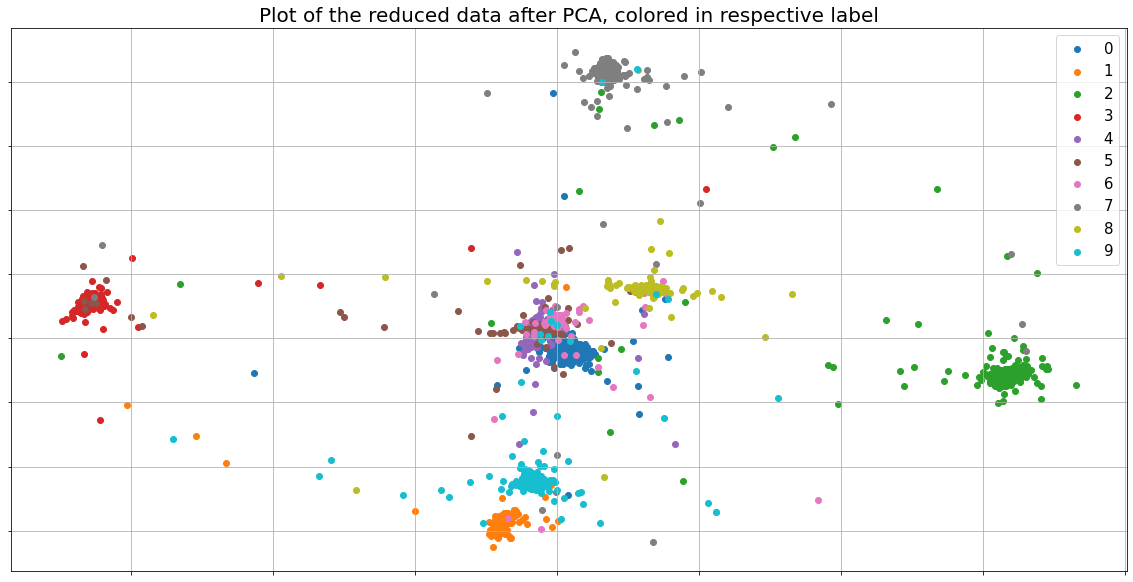

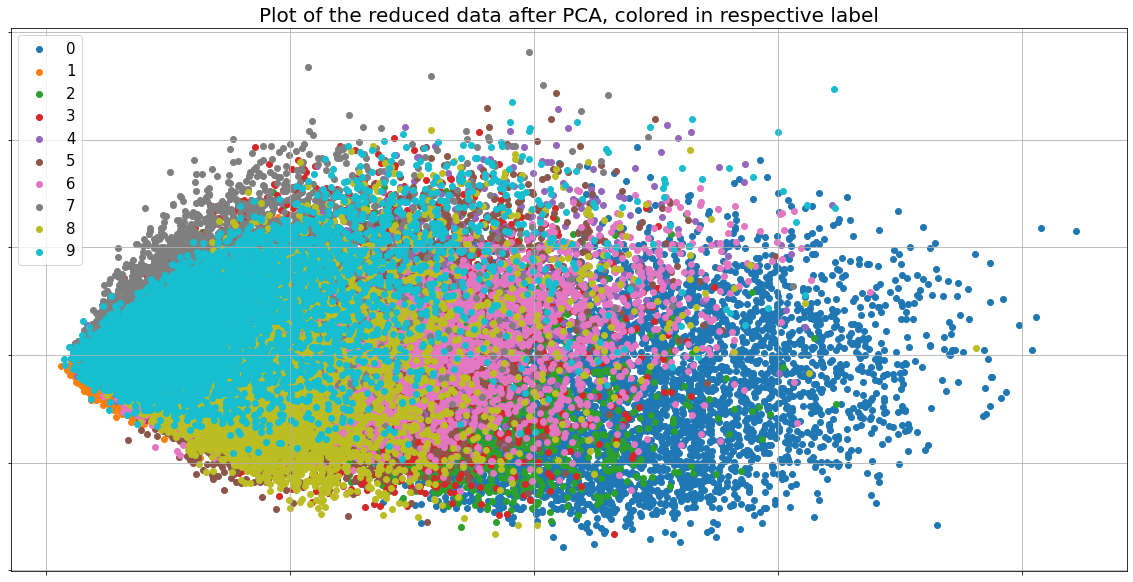

In [9]:
## transform data with Triplet Loss NN and PCA
X = nn.predict(test_X)
y = pd.DataFrame(test_y)
X_new, y = pca(X, y)
## transform data with a PCA
X_new_original, y_original = pca(train_X, train_y)

## plot result of NN + Triplet Loss + PCA
plot_reduced_data(X_new, y)
## plot result of PCA
plot_reduced_data(X_new_original, pd.DataFrame(y_original))

### 4. Simple Classifier (KNN / SVM) depending on success of step 4 and task itself (anomaly detection, Computer Vision, time series)

&rightarrow; KNN with high train speed but lower prediction speed, SVM takes much longer but has faster prediction times
    
&rightarrow; NN only for Computer Vision task (=CNN), maybe time series
    
&rightarrow; for Anomaly Detection use maybe Autoencoder (overkill?) or IsolationForest, maybe simple clustering?
### 5. Evaluation of classification success

c:\python36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Acc: 97.01%
Precision: 0.97
Recall: 0.97
F1 score: 0.97
Acc: 35.73%
Precision: 0.35
Recall: 0.37
F1 score: 0.35


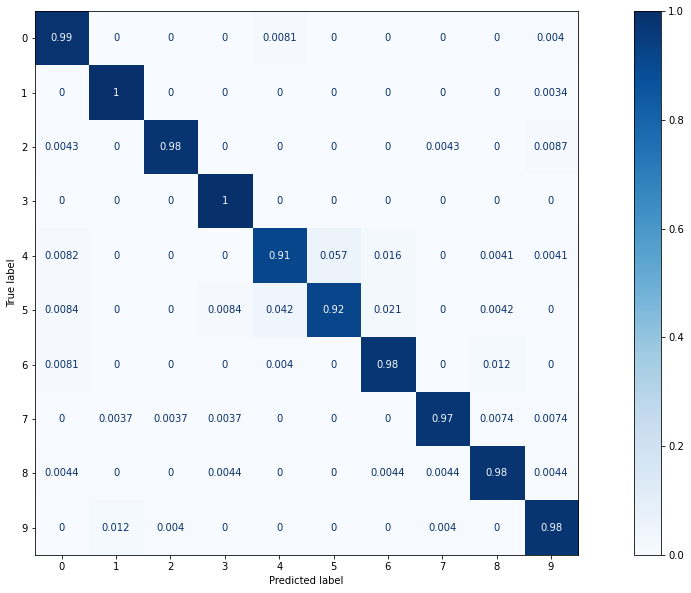

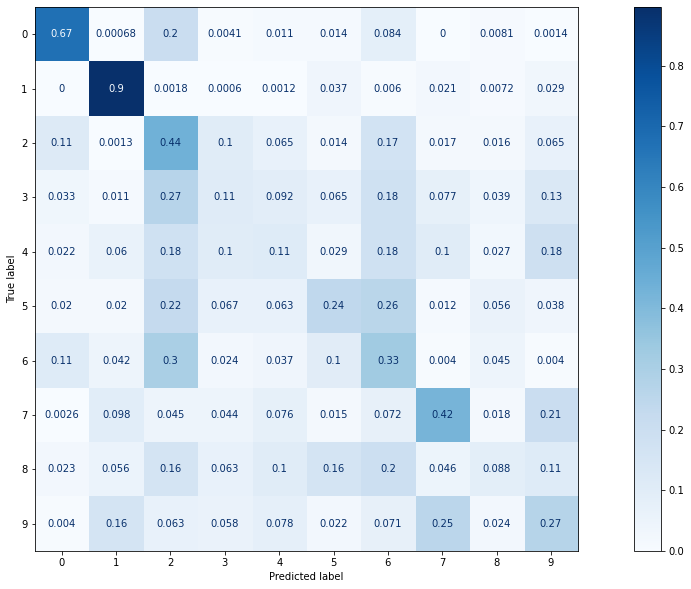

In [10]:
## evaluate NN + Triplet Loss + PCA
evaluate_model(clf, X_new, y)
## evaluate PCA
evaluate_model(clf, X_new_original, y_original)